In [1]:
from models.classification_model import ClassifierModel # class with classifiers
from models.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 
from cycler import cycler
# ide_plot() #plot for github dark theme

In [2]:
plt.rcParams["axes.facecolor"] = 'w'
plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["axes.labelcolor"] = 'black'
plt.rcParams["grid.color"] = 'black'
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.labelcolor"] = 'black'
plt.rcParams["axes.titlecolor"] = 'black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['g', 'r', 'b', 'y'])

In [3]:
import joblib

reduce_model = joblib.load("models/best/reduce_model.pkl")

c_model = joblib.load("models/best/c_model.pkl")

res = joblib.load("models/best/best_params.pkl")

scaler = joblib.load("models/best/scaler.pkl")


In [4]:
test_mofs = pd.read_csv("test_cifs.csv", index_col=0)
test_mofs = pd.DataFrame(reduce_model.transform(test_mofs.values), index=test_mofs.index,)

In [5]:
test_mofs

0         1         2         3         4         5  \
1-final         3.284673 -1.422195 -2.102811 -4.860344 -1.080255 -4.728310   
2-final         3.286075 -1.421376 -2.104950 -4.858925 -1.080578 -4.731123   
2080270         0.567122  0.085580 -2.411250 -4.089851 -0.203309 -2.979827   
2080334         0.492588  0.093742 -2.356460 -3.997657 -0.172882 -2.969380   
CSV157 initial  3.251403 -2.384271 -3.966932 -4.962783 -3.109287 -4.289739   
CSV158 initial  3.412864 -2.354106 -3.946173 -5.075735 -3.140628 -4.274045   

                       6         7         8         9  
1-final        -1.092881  0.019246 -1.420921  1.190130  
2-final        -1.093828  0.016528 -1.417691  1.189848  
2080270         0.860138  3.009019 -2.821081  2.846363  
2080334         0.694580  3.049262 -2.787228  2.852643  
CSV157 initial  0.645156 -1.248142 -2.628460  1.635036  
CSV158 initial  0.766914 -1.158762 -2.728949  1.622409

In [6]:
# load QMOF
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())
qmof_reduced_scaled = scaler.transform(qmof_reduced)
# load MOFs with T and solvent PT
t_solvent = np.load("preprocessing/datasets/t_solvent.npy")

In [7]:
import joblib

reduce_model = joblib.load("models/best/reduce_model.pkl")

c_model = joblib.load("models/best/c_model.pkl")

scaler = joblib.load("models/best/scaler.pkl")


In [8]:
# Load main dataset
dataset = pd.read_csv("preprocessing/datasets/main_dataset.csv", index_col=0)
target = pd.read_csv("preprocessing/datasets/main_target.csv", index_col=0)

In [9]:
# reduce main dataset
main_reduced = pd.DataFrame(reduce_model.transform(dataset), index=dataset.index)
# reduce QMOF
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())

In [10]:
# concatenate QMOF, main, T-Solvent 
cat_ = np.array([*qmof_reduced, *main_reduced.values, *t_solvent, *test_mofs.values])


In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(scaler.transform(cat_))

In [12]:
# X_t -- TSNE of QMOF and main, t_s of T-Solvent 
X_t, tests = X_t[:-6,:], X_t[-6:, :]
X_t, t_s = X_t[:-3,:], X_t[-3:, :]

In [13]:
xt_q = X_t[:qmof_reduced.shape[0]] # QMOF

xt_m = X_t[qmof_reduced.shape[0]:] # main
pr_m = target.values.ravel()

In [14]:
pr_q = {name: c_model.models[name].predict_proba(qmof_reduced_scaled)[:,1] for name in c_model.models} # predicted probability 

# Figures

In [15]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap

In [16]:
summer = mpl.colormaps['summer'].resampled(250)
newcolors = summer(np.linspace(0, 1, 250))
gray = np.array([110/250, 112/250, 110/250, 1])
green = np.array([0/250,128/250,0,1])
yellow = np.array([1,1,0,1])
gap = 0.2
top, bottom = int(len(newcolors) * 0.8), int(len(newcolors) * 0.2)
newcolors[top:, :] = yellow
newcolors[bottom:top, :] = gray
newcolors[:bottom, :] = green
newcmp = ListedColormap(newcolors)

In [17]:
def plot_high_confident(ax, name):
    gap = 0.2
    ax.set_title(name, size=20)
    guest_mol_ind = np.where(pr_q[name] >= 1 - gap)[0]
    tp_ind = np.where(pr_q[name] <= gap)[0]
    no_transition = np.where([p < 1- gap and p > gap for p in pr_q[name]])[0]
    ax.scatter(xt_q[no_transition, 0], xt_q[no_transition, 1], s=80, alpha=0.5, linewidths=0.3, edgecolors='black', c="gray") # label="no prediction"
    ax.scatter(xt_q[guest_mol_ind, 0], xt_q[guest_mol_ind, 1], s=80, alpha=1, linewidths=0.3, edgecolors='black', c='yellow', label=f"guest mol. ({len(guest_mol_ind)})") # label=f"predicted guest mol. transform: {len(guest_mol_ind)}"
    ax.scatter(xt_q[tp_ind, 0], xt_q[tp_ind, 1], s=60, alpha=1, linewidths=0.3, edgecolors='black', c='green',  label=f"T-P ({len(tp_ind)})") # label=f"predicted T-P transform: {len(tp_ind)}"
    ax.scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], marker='v', edgecolors='r', color='green', s=100) # , label='t-p (main)'
    ax.scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], marker='v', edgecolors='r', color='yellow', s=100) # , label='guest molecules (main)'
    #ax.legend(loc=2, fontsize="large")
    ax.axis("equal")
    ax.tick_params(axis='both',label1On=False, size=5)
    ax.set_xlabel("TSNE1", size=20)
    ax.set_ylabel("TSNE2", size=20)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    print(f"{name}: number of predicted MOFs with ability to s. tr. under guest mol.: {len(guest_mol_ind)} ")
    print(f"{name}: number of predicted MOFs with ability to s. tr. T-P : {len(tp_ind)} ")



In [18]:
a = [715,355,239,1833,3946,266,210,74,572,636,213,113,54,716,608,593,3526,1775,2610,68,197,182,948]

In [19]:
c_model.models["kNN"].predict_proba(scaler.transform(t_solvent))[:,1]

array([0.        , 0.83196946, 0.        ])

In [20]:
d = pd.read_csv("test_cifs.csv", index_col=0)

In [21]:
d

pld       lcd         a         b         c     alpha  \
1-final         0.034348  0.055998  0.180014  0.276062  0.150516  0.640777   
2-final         0.033268  0.054708  0.178766  0.272011  0.147756  0.639074   
2080270         0.292649  0.267515  0.647961  0.623257  0.387075  0.578143   
2080334         0.859632  0.848173  0.428584  0.396645  0.232675  0.578143   
CSV157 initial  0.037645  0.066299  0.186017  0.153954  0.067319  0.578143   
CSV158 initial  0.024311  0.017708  0.128440  0.127476  0.049278  0.578143   

                   beta     gamma    volume  spacegroupNumber  ...   Zagreb2  \
1-final         0.52696  0.441638  0.070942          0.013216  ...  0.094290   
2-final         0.52696  0.441638  0.069715          0.013216  ...  0.094290   
2080270         0.52696  0.441638  0.487360          0.400881  ...  0.367862   
2080334         0.52696  0.441638  0.246818          0.396476  ...  0.367862   
CSV157 initial  0.52696  0.441638  0.024748          0.140969  ...  0.094290   
CSV158 initial  0.52696  0.757346  0.018578          0.057269  ...  0.094290   

                mZagreb1  mZagreb2  n_metals  Atomic_Number  Atomic_Weight  \
1-final         0.053253  0.101504  0.000000       0.269663       0.224989   
2-final         0.053253  0.101504  0.000000       0.280899       0.223951   
2080270         0.378774  0.406015  0.090909       0.269663       0.224989   
2080334         0.378774  0.406015  0.090909       0.269663       0.224989   
CSV157 initial  0.053253  0.101504  0.181818       0.202247       0.163904   
CSV158 initial  0.053253  0.101504  0.000000       0.292135       0.244950   

                Atomic Radius  Mulliken EN  polarizability(A^3)  \
1-final              0.188889     0.790378             0.049270   
2-final              0.172222     0.824742             0.036496   
2080270              0.188889     0.790378             0.049270   
2080334              0.188889     0.790378             0.049270   
CSV157 initial      -0.094444     1.727377            -0.020073   
CSV158 initial       0.150000     0.852234             0.034672   

                electron affinity(kJ/mol)  
1-final                          0.190071  
2-final                          0.258156  
2080270                          0.190071  
2080334                          0.190071  
CSV157 initial                   0.485579  
CSV158 initial                   0.268085  

[6 rows x 1018 columns]

In [22]:
cat_[-6:,:]

array([[ 3.2846735 , -1.4221954 , -2.1028109 , -4.8603444 , -1.0802546 ,
        -4.7283096 , -1.0928814 ,  0.01924588, -1.4209213 ,  1.1901305 ],
       [ 3.2860749 , -1.4213755 , -2.1049502 , -4.8589253 , -1.0805782 ,
        -4.731123  , -1.0938276 ,  0.01652816, -1.4176913 ,  1.1898477 ],
       [ 0.5671219 ,  0.08557972, -2.4112504 , -4.0898514 , -0.20330925,
        -2.9798272 ,  0.8601378 ,  3.009019  , -2.8210807 ,  2.846363  ],
       [ 0.49258813,  0.09374216, -2.3564596 , -3.997657  , -0.17288153,
        -2.9693797 ,  0.69458   ,  3.0492623 , -2.787228  ,  2.852643  ],
       [ 3.251403  , -2.384271  , -3.966932  , -4.962783  , -3.1092868 ,
        -4.2897387 ,  0.64515626, -1.2481415 , -2.6284597 ,  1.635036  ],
       [ 3.412864  , -2.3541057 , -3.946173  , -5.0757346 , -3.1406276 ,
        -4.2740455 ,  0.7669142 , -1.1587617 , -2.7289493 ,  1.6224092 ]],
      dtype=float32)

In [23]:
red = reduce_model.transform(d.values)

In [24]:
for name, proba in zip(d.index, c_model.models["kNN"].predict_proba(scaler.transform(red))[:, 1]):
    print(name, proba)

1-final 0.08964119592893176
2-final 0.08851585396110757
2080270 0.0
2080334 0.0
CSV157 initial 0.6648724766005583
CSV158 initial 0.6653018145969616


In [25]:
train, test = pd.read_csv("preprocessing/datasets/qmof_train.csv", index_col=0), pd.read_csv("preprocessing/datasets/qmof_train.csv", index_col=0)
d = pd.concat([train, test], axis=0)

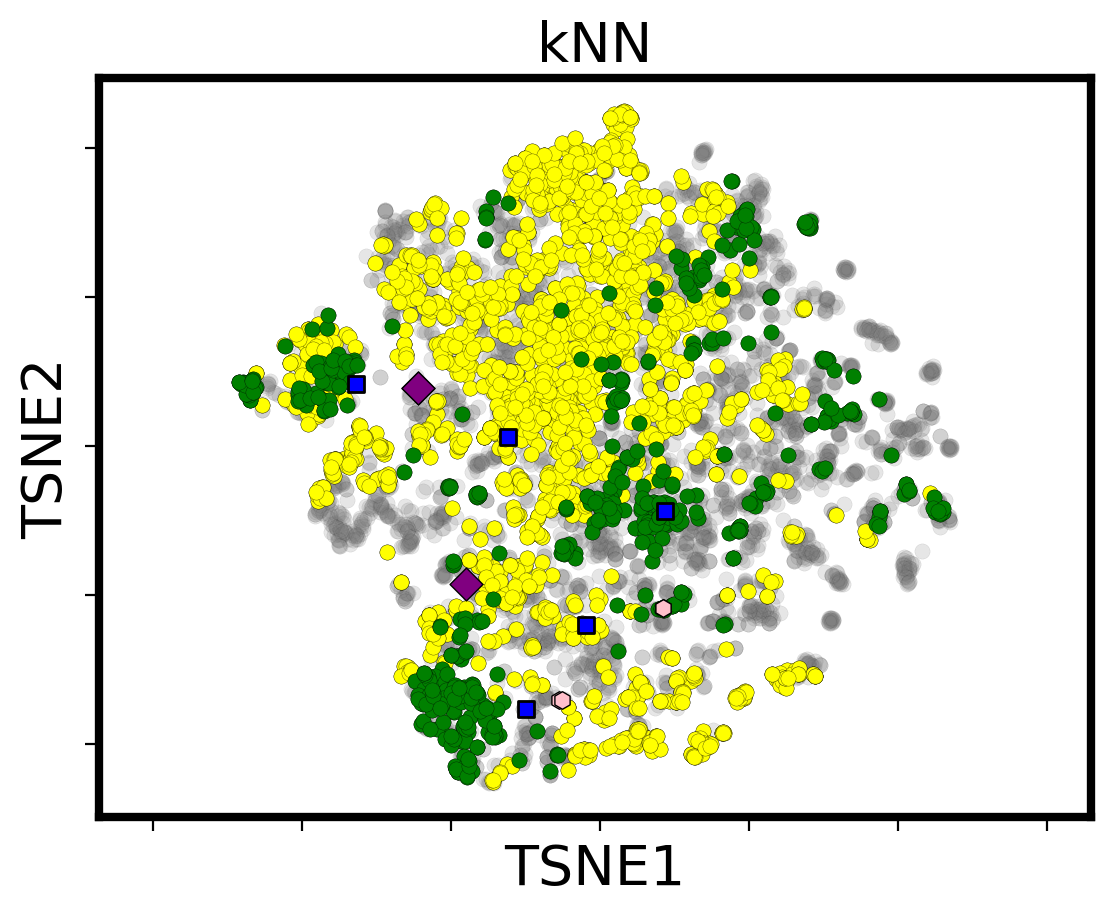

In [26]:
# plot support 

fig, ax = plt.subplots(1, 1, dpi=200)
gap = 0.2
ax.set_title("kNN", size=20)
guest_mol_ind = np.where(pr_q["kNN"] >= 1 - gap)[0]
tp_ind = np.where(pr_q["kNN"] <= gap)[0]
no_transition = np.where([p < 1- gap and p > gap for p in pr_q["kNN"]])[0]
ax.scatter(xt_q[no_transition, 0], xt_q[no_transition, 1], s=30, alpha=0.1, linewidths=0.1, edgecolors='black', c="gray") # label="no prediction"
ax.scatter(xt_q[guest_mol_ind, 0], xt_q[guest_mol_ind, 1], s=30, alpha=1, linewidths=0.1, edgecolors='black', c='yellow', label=f"guest mol. ({len(guest_mol_ind)})") 
ax.scatter(xt_q[tp_ind, 0], xt_q[tp_ind, 1], s=30, alpha=1, linewidths=0.1, edgecolors='black', c='green',  label=f"T-P ({len(tp_ind)})") # label=f"predicted T-P transform: {len(tp_ind)}"
ax.axis("equal")
ax.tick_params(axis='both',label1On=False, size=5)
ax.set_xlabel("TSNE1", size=20)
ax.set_ylabel("TSNE2", size=20)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

described = [
            1833, # 3
            # 266,  # 5
            572,  # 8
            213,  # 10
            2610, # 18
            182   # 21
            ]
d_names = ["VEXPAS_FSR",
           "COWKIJ_FSR",
           "TABQAR_FSR",
           "HUTZAX_FSR",
           "RINWAO_FSR"]
ax.scatter(xt_q[described, 0], xt_q[described, 1], s=30, marker="s", alpha=1, linewidths=1, edgecolor='black', c='blue')
# for i, ind in enumerate(described):
#     ax.text(xt_q[ind, 0]-20, xt_q[ind, 1]+5, d_names[i])
ax.scatter(t_s[:, 0], t_s[:, 1], s=70, marker="D", alpha=1, edgecolors='black', linewidths=0.5, c='purple')

ax.scatter(tests[[0, 1, 4, 5], 0], tests[[0, 1, 4, 5], 1], s=40, marker="h", alpha=1, edgecolors='black', linewidths=0.5, c='pink')
# for i, name in enumerate(test_mofs.index):
#     ax.text(tests[i, 0], tests[i, 1] + np.random.random()*20, name)

# plt.savefig("tsne_with_Described_T_Sol_tests.pdf")

# for point, name in zip(t_s, ["topart4", "from11974527", "frompart2"]):
#     ax.text(point[0], point[1] + np.random.rand()*20, name)



In [27]:
def plot_high_confident(ax, name):
    gap = 0.2
    ax.set_title(name, size=6)
    guest_mol_ind = np.where(pr_q[name] >= 1 - gap)[0]
    tp_ind = np.where(pr_q[name] <= gap)[0]
    no_transition = np.where([p < 1- gap and p > gap for p in pr_q[name]])[0]
    ax.scatter(xt_q[no_transition, 0], xt_q[no_transition, 1], s=10, alpha=0.5, linewidths=0.1, edgecolors='black', c="#a1a1a1") # label="no prediction"
    ax.scatter(xt_q[guest_mol_ind, 0], xt_q[guest_mol_ind, 1], s=10, alpha=1, linewidths=0.1, edgecolors='black', c='yellow', label=f"guest mol. ({len(guest_mol_ind)})") # label=f"predicted guest mol. transform: {len(guest_mol_ind)}"
    ax.scatter(xt_q[tp_ind, 0], xt_q[tp_ind, 1], s=10, alpha=1, linewidths=0.1, edgecolors='black', c='green',  label=f"T-P ({len(tp_ind)})") # label=f"predicted T-P transform: {len(tp_ind)}"
    ax.scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], marker='v', linewidths=0.7, edgecolors='r', color='green', s=15) # , label='t-p (main)'
    ax.scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], marker='v', linewidths=0.7, edgecolors='r', color='yellow', s=15) # , label='guest molecules (main)'
    #ax.legend(loc=2, fontsize="large")
    ax.axis("equal")
    ax.tick_params(axis='both',label1On=False, size=2)
    ax.set_xlabel("TSNE1", size=6)
    ax.set_ylabel("TSNE2", size=6)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    print(f"{name}: number of predicted MOFs with ability to s. tr. under guest mol.: {len(guest_mol_ind)} ")
    print(f"{name}: number of predicted MOFs with ability to s. tr. T-P : {len(tp_ind)} ")


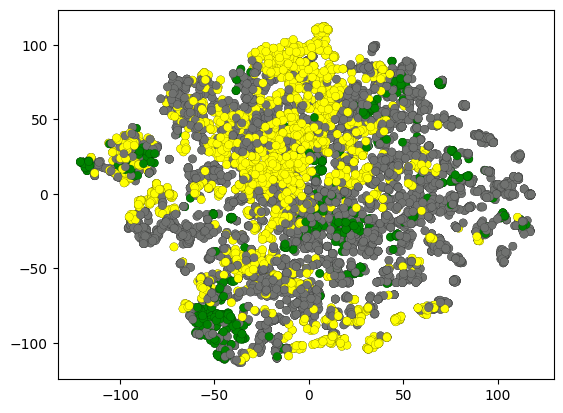

In [28]:
map = plt.scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, edgecolors='black', c=pr_q["kNN"], cmap=newcmp)


CatBoost: number of predicted MOFs with ability to s. tr. under guest mol.: 0 
CatBoost: number of predicted MOFs with ability to s. tr. T-P : 0 
kNN: number of predicted MOFs with ability to s. tr. under guest mol.: 3924 
kNN: number of predicted MOFs with ability to s. tr. T-P : 1228 
AdaBoost: number of predicted MOFs with ability to s. tr. under guest mol.: 6334 
AdaBoost: number of predicted MOFs with ability to s. tr. T-P : 3674 
RF: number of predicted MOFs with ability to s. tr. under guest mol.: 2086 
RF: number of predicted MOFs with ability to s. tr. T-P : 348 


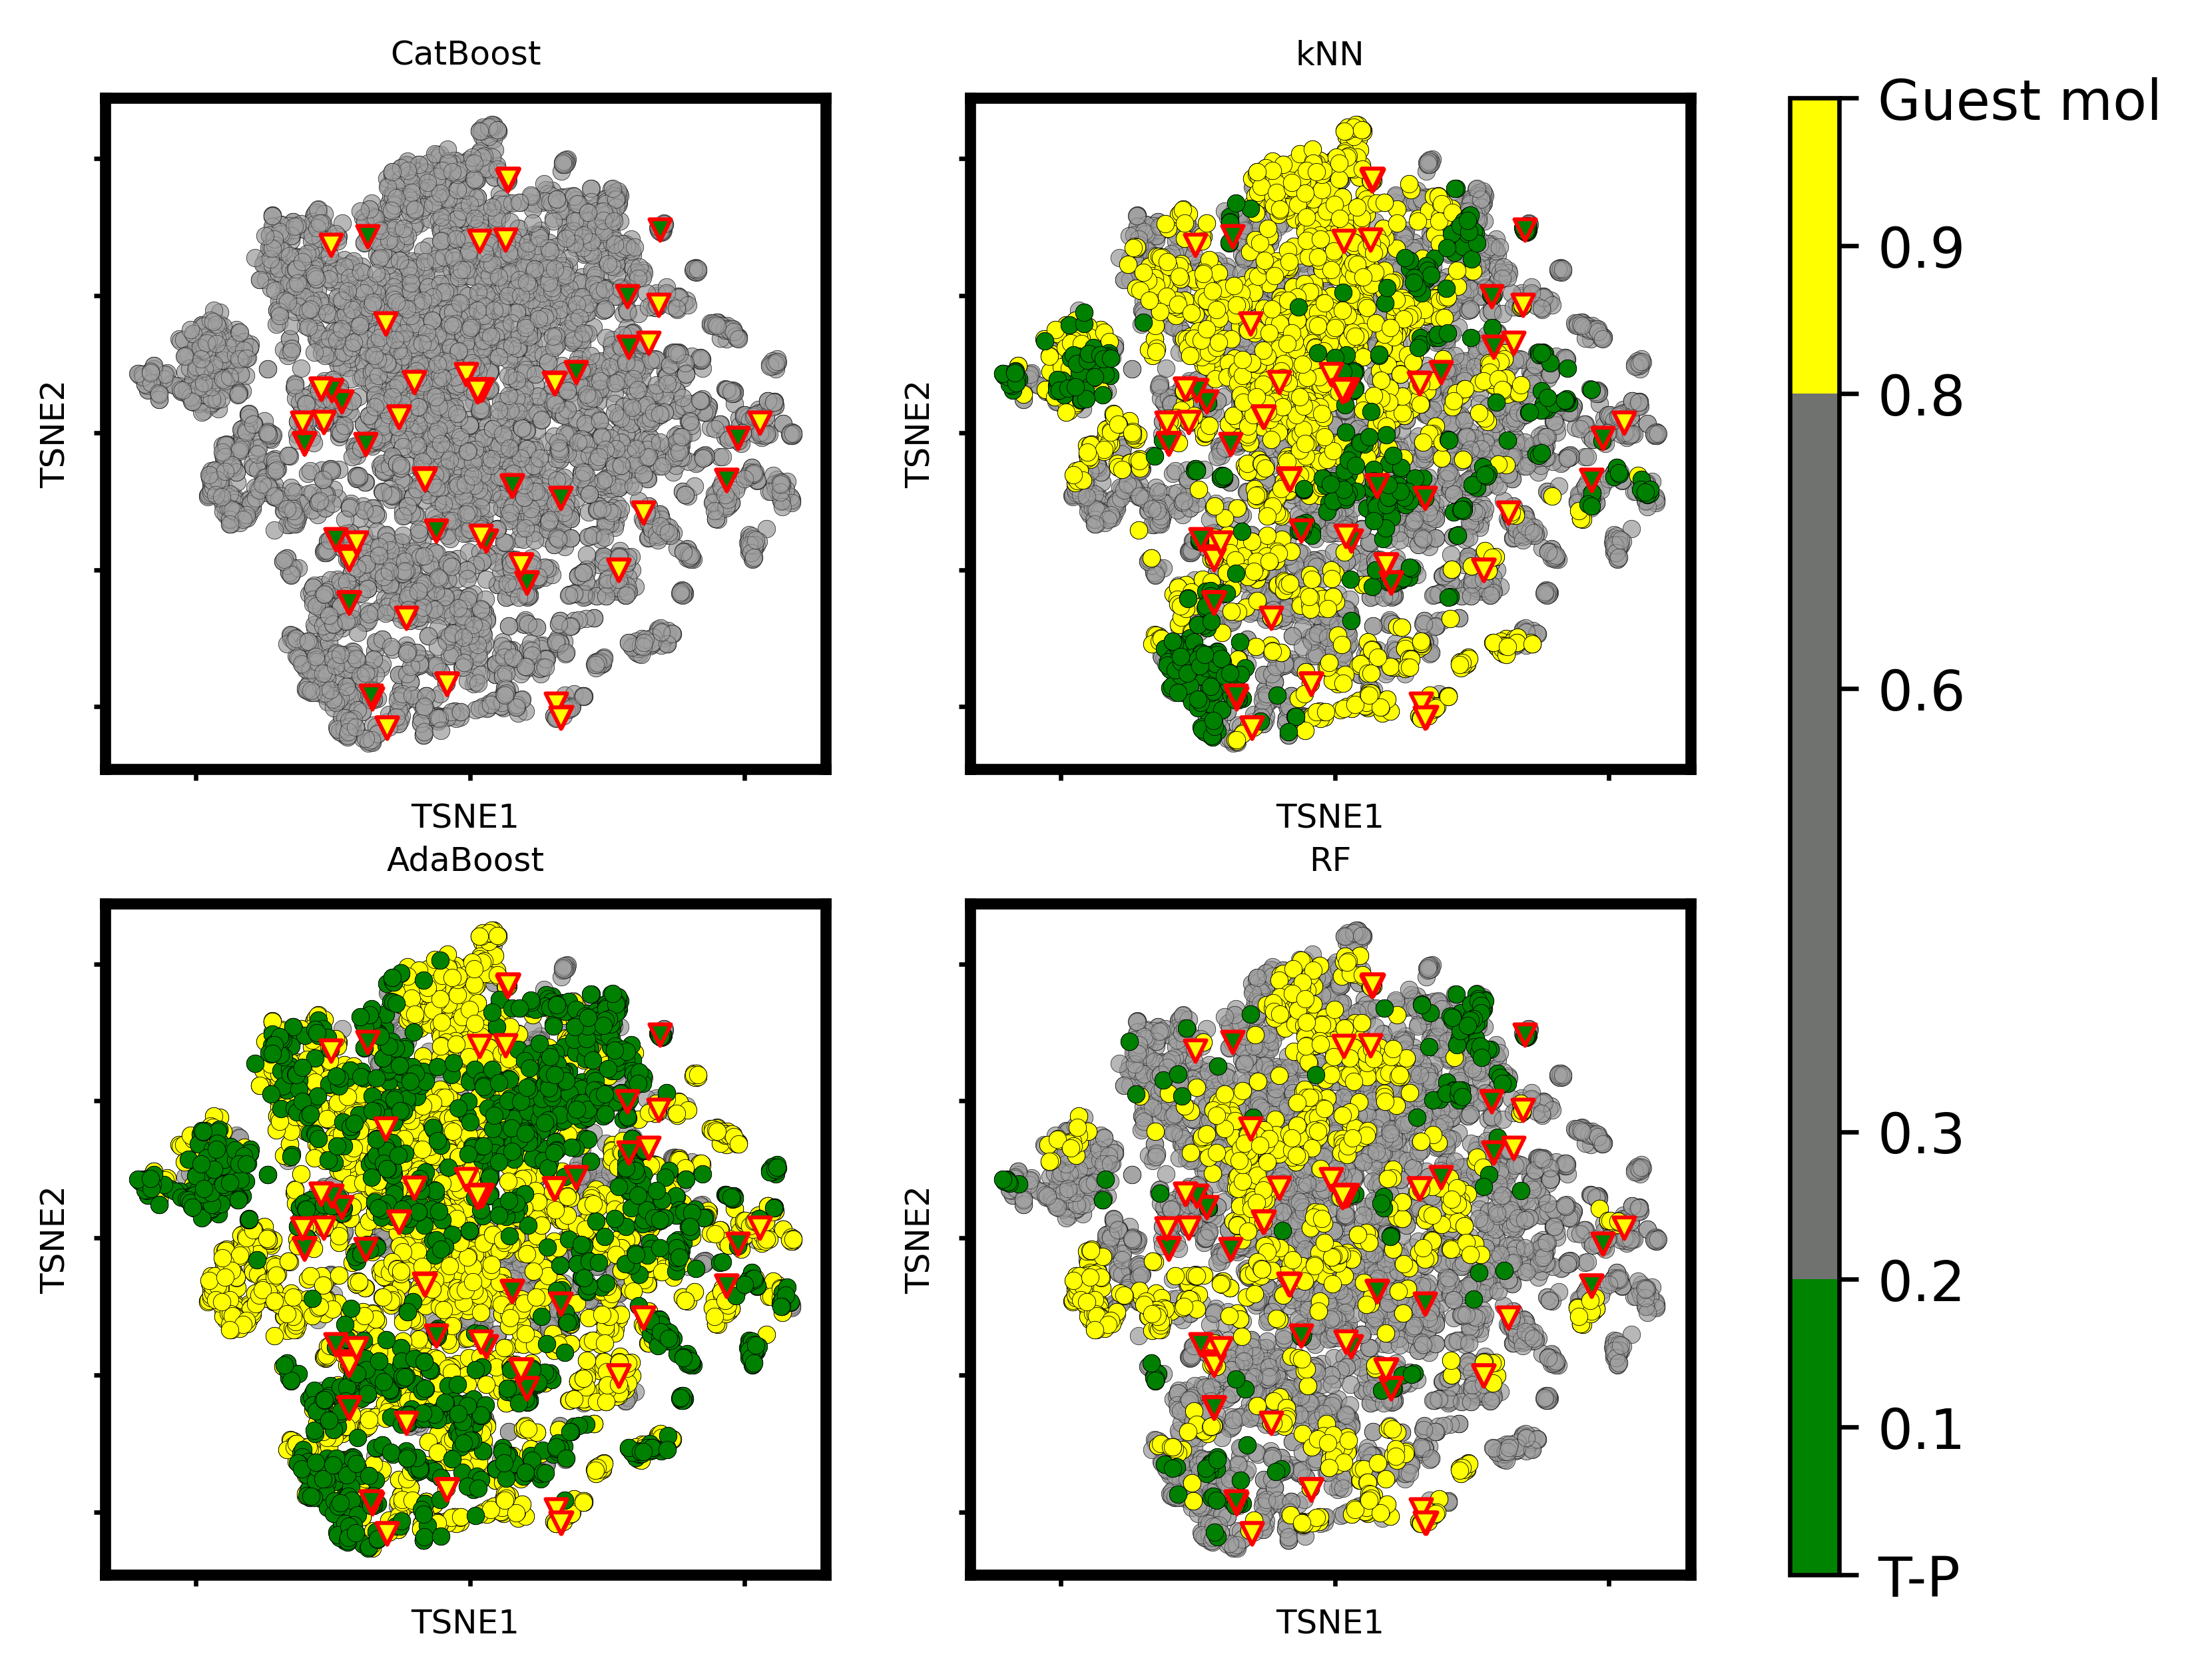

In [29]:
fig, axis = plt.subplots(2, 2, dpi=600)
plot_high_confident(axis[0][0], "CatBoost")
plot_high_confident(axis[0][1], "kNN")
# for i, ind in enumerate(chosen):
#     axis[0][1].text(xt_q[ind, 0], xt_q[ind, 1], str(i), fontsize=10)

# axis[0][1].scatter(xt_q[chosen, 0], xt_q[chosen, 1], s=30, marker="s", alpha=1, linewidths=1, c='blue')
plot_high_confident(axis[1][0], "AdaBoost")
plot_high_confident(axis[1][1], "RF")
bar = fig.colorbar(map, ax=axis, ticks=[0, 0.1, 0.2, 0.3, 0.6, 0.8,  0.9, 1], aspect=30)
bar.set_ticklabels(["T-P", 0.1, 0.2, 0.3, 0.6, 0.8,  0.9, "Guest mol"], size=10)
# plt.savefig("tsne.png")

# fig.colorbar()

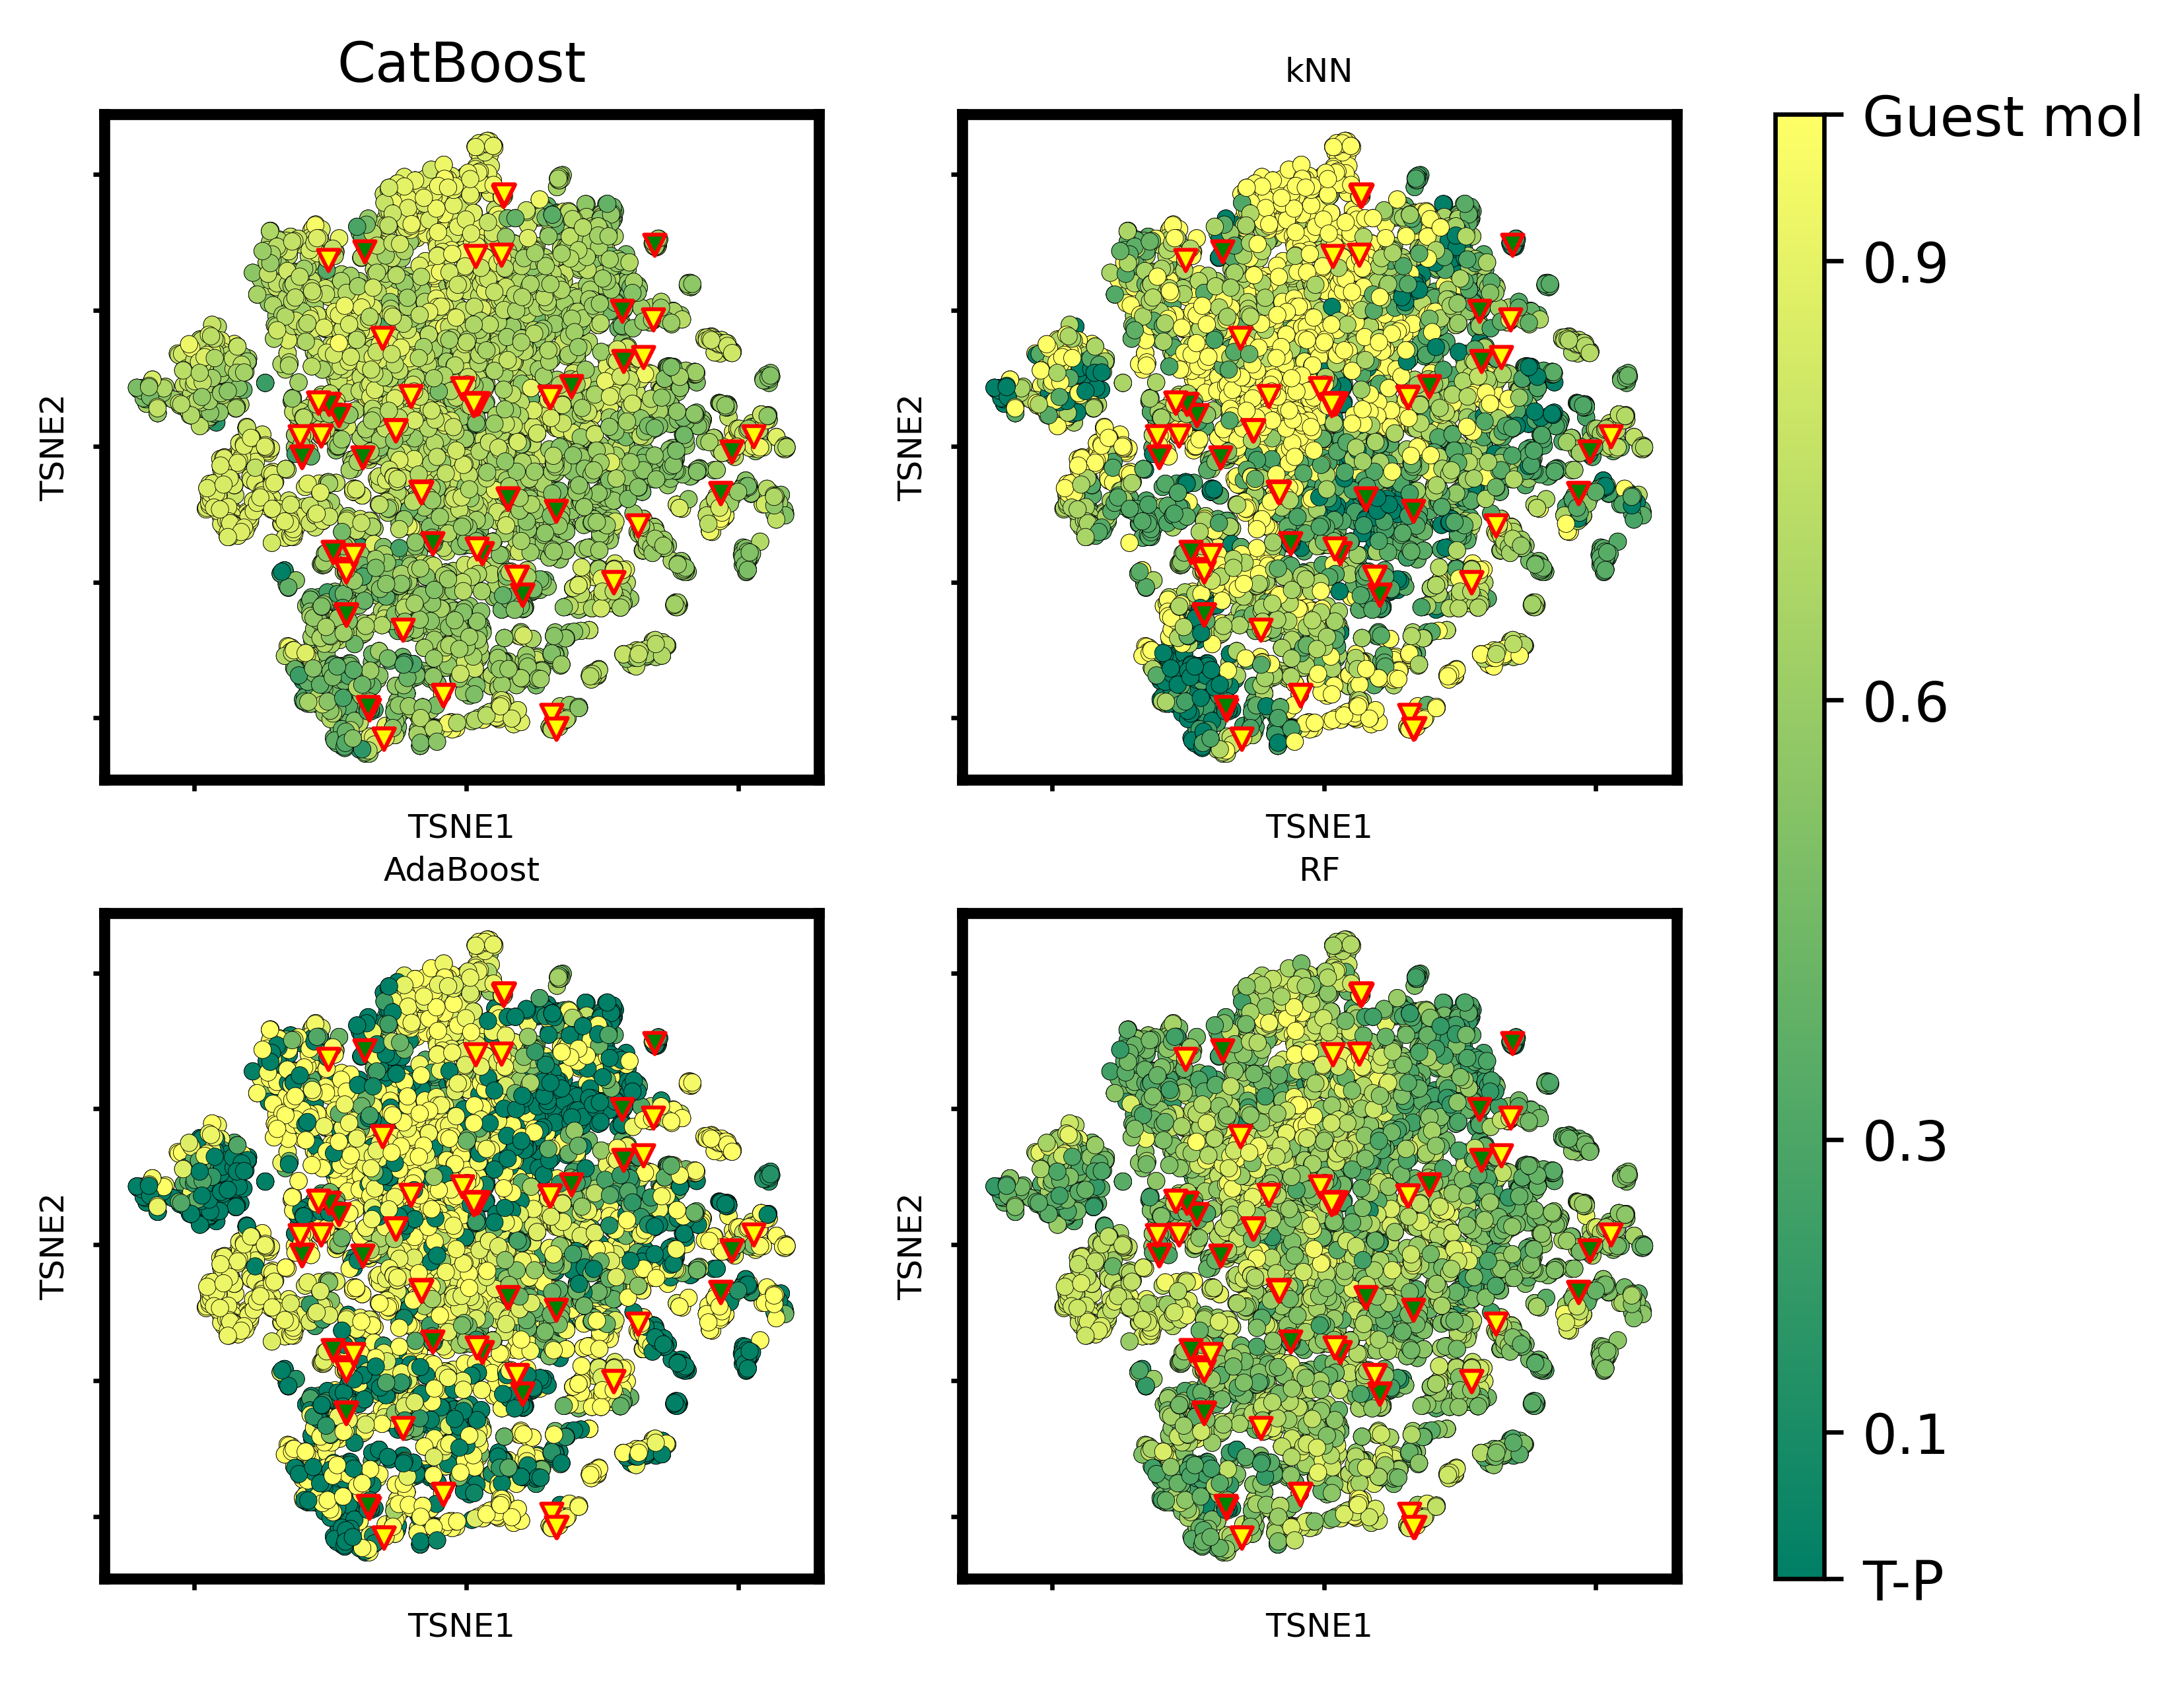

In [30]:
fig, axis = plt.subplots(2, 2, dpi=600)

axis[0][0].scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, s=10, edgecolors='black', c=pr_q["CatBoost"], cmap="summer")
axis[0][0].scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], linewidths=0.7, marker='v', edgecolors='r', color='green', s=15, label='t-p (main)')
axis[0][0].scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], linewidths=0.7, marker='v', edgecolors='r', color='yellow', s=15, label='guest molecules (main)')
axis[0][0].set_title("CatBoost", size=10)
axis[0][0].axis("equal")

axis[0][0].tick_params(axis='both',label1On=False, size=2)
axis[0][0].set_xlabel("TSNE1", size=6)
axis[0][0].set_ylabel("TSNE2", size=6)
for a in ['top','bottom','left','right']:
    axis[0][0].spines[a].set_linewidth(2)


axis[0][1].scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, s=10, edgecolors='black', c=pr_q["kNN"], cmap="summer")
axis[0][1].scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], linewidths=0.7, marker='v', edgecolors='r', color='green', s=15, label='t-p (main)')
axis[0][1].scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], linewidths=0.7, marker='v', edgecolors='r', color='yellow', s=15, label='guest molecules (main)')
axis[0][1].set_title("kNN", size=6)
axis[0][1].axis("equal")

axis[0][1].tick_params(axis='both',label1On=False, size=2)
axis[0][1].set_xlabel("TSNE1", size=6)
axis[0][1].set_ylabel("TSNE2", size=6)
for a in ['top','bottom','left','right']:
    axis[0][1].spines[a].set_linewidth(2)

axis[1][0].scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, s=10, edgecolors='black', c=pr_q["AdaBoost"], cmap="summer")
axis[1][0].scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], linewidths=0.7, marker='v', edgecolors='r', color='green', s=15, label='t-p (main)')
axis[1][0].scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], linewidths=0.7, marker='v', edgecolors='r', color='yellow', s=15, label=' guest molecules (main)')
axis[1][0].set_title("AdaBoost", size=6)
axis[1][0].axis("equal")

axis[1][0].tick_params(axis='both',label1On=False, size=2)
axis[1][0].set_xlabel("TSNE1", size=6)
axis[1][0].set_ylabel("TSNE2", size=6)
for a in ['top','bottom','left','right']:
    axis[1][0].spines[a].set_linewidth(2)

map = axis[1][1].scatter(xt_q[:, 0], xt_q[:, 1], alpha=1, linewidths=0.1, s=10, edgecolors='black', c=pr_q["RF"], cmap="summer")
axis[1][1].scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], linewidths=0.7, marker='v', edgecolors='r', color='green', s=15, label='t-p (main)')
axis[1][1].scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], linewidths=0.7, marker='v', edgecolors='r', color='yellow', s=15, label='guest molecules  (main)')
axis[1][1].set_title("RF", size=6)
axis[1][1].axis("equal")

axis[1][1].tick_params(axis='both',label1On=False, size=2)
axis[1][1].set_xlabel("TSNE1", size=6)
axis[1][1].set_ylabel("TSNE2", size=6)
for a in ['top','bottom','left','right']:
    axis[1][1].spines[a].set_linewidth(2)

# axis[0][0].legend()
bar = fig.colorbar(map, ax=axis, ticks=[0, 0.1, 0.3, 0.6, 0.9, 1], aspect=30)
bar.set_ticklabels(["T-P", 0.1, 0.3, 0.6, 0.9, "Guest mol"])